# Machine Learning Project

### Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from numpy.random import random, seed
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display
from scipy.stats import norm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression



### Defined functions

In [34]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def create_X(x, y, n=1 ):
    '''from x, y meshgrid vectors computes the design matrix for a polynomial model of degree n.'''
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    
    for i in range(1,n+1):
        #starting from the index after the i-1 degree
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            #combinations of powers of x and y, starting from x**i
            X[:,q+k] = (x**(i-k))*(y**k)
            
    # The design matrix is set up as 1,x,y,x**2,x*y,y**2
    return X

def OLS(X_train, X_test, z_train, z_test):
    '''
    Fit the model with OLS regression using the train set and 
    returns the predicted values for both the train and the test set.
    '''
    
    #extract regression coefficients
    beta_ols = np.linalg.pinv(X_train.T@X_train)@(X_train.T)@z_train
    
    #predict train and test values
    z_train_tilde_ols = X_train@beta_ols
    z_test_tilde_ols = X_test@beta_ols
    
    return z_train_tilde_ols, z_test_tilde_ols

#Important to split the data set before shuffling 
def bootstrap_OLS(X_train, X_test, z_train, z_test, n_bootstrap): 
    MSE = np.zeros((n_bootstrap,2))
    n = len(z_train)
    z_tilde_train_ols = np.empty((len(z_train), n_bootstrap))
    z_tilde_test_ols = np.empty((len(z_test), n_bootstrap))
    for i in range(n_bootstrap):
        sequence = np.random.randint(0,n,n)
        X1_train = X_train[sequence]
        z1_train = z_train[sequence]  
        z_tilde_train_ols[:,i] , z_tilde_test_ols[:,i] = OLS(X1_train, X_test, z1_train, z_test) 
        MSE[i,0] = mean_squared_error(z1_train,z_tilde_train_ols[:,i]) 
        MSE[i,1] = mean_squared_error(z_test,z_tilde_test_ols[:,i])  
    return z_tilde_train_ols, z_tilde_test_ols, MSE
# From now on, index 0 corresponds to train and 1 to test

def cross_validation_OLS(k_folds, X,z):
    MSE_train = []
    MSE_test = []
    kfold = KFold(n_splits = k_folds)
    for train_inds, test_inds in kfold.split(X):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]

        z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test)
        
        MSE_train.append(mean_squared_error(z_train, z_train_tilde_ols))
        MSE_test.append(mean_squared_error(z_test, z_test_tilde_ols))
        
    MSE_train_mean = np.mean(MSE_train)
    MSE_test_mean = np.mean(MSE_test)
    return MSE_train_mean, MSE_test_mean

def Ridge(X_train,X_test,z_train,z_test,lambd):

    # Since it relates to remove intercepts, better to use built in function in SKL
    RegRidge = linear_model.Ridge(lambd,fit_intercept= True)
    
    #fit the model to the training data
    RegRidge.fit(X_train,z_train)
    
    # and then make the prediction
    z_tilde_train = RegRidge.predict(X_train)
    z_tilde_test = RegRidge.predict(X_test)
    
    return z_tilde_train, z_tilde_test

#Important to split the data set before shuffling 
def bootstrap_Ridge(X_train, X_test, z_train, z_test, n_bootstrap, lambd): 
    
    #prepare arrays for output
    MSE = np.zeros((n_bootstrap,2))
    z_tilde_train = np.zeros((len(z_train), n_bootstrap))
    z_tilde_test = np.zeros((len(z_test), n_bootstrap))
    
    n = len(z_train)
    
    #cycle on resamplings
    for i in range(n_bootstrap):
        
        #extract sequence for resampling
        sequence = np.random.randint(0,n,n)
        
        #resampled arrays
        X1_train = X_train[sequence]
        z1_train = z_train[sequence]
        
        #fit and predict
        z_tilde_train[:,i], z_tilde_test[:,i] = Ridge(X1_train, X_test, z1_train, z_test, lambd)
        
        #calculate mse on train and test
        MSE[i,0] = mean_squared_error(z1_train,z_tilde_train[:,i])
        MSE[i,1] = mean_squared_error(z_test,z_tilde_test[:,i])

    return z_tilde_train, z_tilde_test, MSE

def cross_validation_Ridge(k_folds, X, z, lambd):
    MSE = []
    kfold = KFold(n_splits = k_folds)
    for train_inds, test_inds in kfold.split(X):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]

        z_tilde_train, z_tilde_test = Ridge( X_train, X_test, z_train, z_test, lambd)

        MSE.append(mean_squared_error(z_test,z_tilde_test))

    return (np.mean(MSE))

### Drawing Franke Function

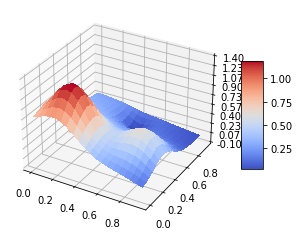

In [3]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## 1. OLS of Franke Function

- Generate the data with added noise following gaussian distribution
- OLS up to 5th order
- Confidence Interval of parameters by computing their variances      !!
- Evaluate MSE and R2
- Should consider scaling of data (subtracting mean value ) 
- Also Split of data into training and test

Additional Questions:

- Effect of noise on this results
- Effect of the scaling on this results

### Data for a)

In [31]:
#number of points for each axis
n_points = 50

#set random seed
np.random.seed(53186)
x0 = np.random.rand(n_points)

#set random seed
np.random.seed(48643)
y0 = np.random.rand(n_points)

#mesh arrays of x and y
x,y = np.meshgrid(x0,y0)

#create a dummy design matrix for the arrays of x and y
X0 = create_X(x,y)

#generate normal distributed noise 
noise_amp = 0.9
noise = noise_amp*np.random.randn(X0.shape[0])

#calculate starting target values with noise
z = FrankeFunction(X0[:,1],X0[:,2]) + noise


# The degree of the polynomial and the corresponding design matrix will be specific of each problem


In [5]:
### Considering the intercept (no scaling)

The MSE test for OLS and degree  5
0.23773716624859553
MSE with intercept column from SKL
0.23773716625041832
The MSE train for OLS and degree  5
0.24893555075946017
R2 scores for 
Test  0.2229047296165273
Train 0.22370585562751433


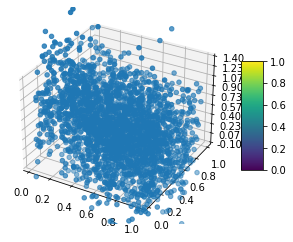

In [21]:
## THIS IS THE FIT CONSIDERING THE INTERCEPT (Intercept included in design matrix)


#degree of the polynomial
maxdegree = 5

#setup design matrix with polynomial model
X = create_X(x,y,maxdegree)


#split train and test set
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=2)


# Intercept is included in the design matrix
skl = LinearRegression(fit_intercept=False).fit(X_train, z_train)

zpredictSKL = skl.predict(X_test)

#apply OLS regression
z_train_tilde_ols, z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test)

#calculate train and test mse 
mse_train = mean_squared_error(z_train,z_train_tilde_ols)
mse_test = mean_squared_error(z_test,z_test_tilde_ols)

#calculate train and test r2
r2_train = r2_score(z_train,z_train_tilde_ols)
r2_test = r2_score(z_test,z_test_tilde_ols)

print("The MSE test for OLS and degree ",maxdegree)
print(mse_test)

print("MSE with intercept column from SKL")
print(mean_squared_error(z_test,zpredictSKL))

print("The MSE train for OLS and degree ",maxdegree)

print(mse_train)

print("R2 scores for ")

print("Test " , r2_test)
print("Train" , r2_train)



fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.scatter3D(X[:,1],X[:,2], z, cmap=cm.coolwarm)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Considering the intercept (with scaling)

In [25]:
## THIS IS THE FIT WITHOUT THE INTERCEPT


#degree of the polynomial
maxdegree = 5

#setup design matrix with polynomial model
X = create_X(x,y,maxdegree)


#split train and test set
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2,random_state=2)


# Intercept is not included in the design matrix
skl = LinearRegression(fit_intercept=True).fit(X_train, z_train)

zpredictSKL = skl.predict(X_test)



# Use centered values for X and y when computing coefficients
z_offset = np.average(z_train, axis=0)
X_offset = np.average(X_train, axis=0)

#apply OLS regression
X_train_sc = X_train-X_offset
z_train_sc = z_train-z_offset

beta = np.linalg.pinv(X_train_sc.T@X_train_sc)@(X_train_sc.T)@z_train_sc


intercept = np.average(z_offset - X_offset @ beta)

zpredictOwn = X_test @ beta

#calculate train and test mse 

mse_train = mean_squared_error(z_train,z_train_tilde_ols)
mse_test = mean_squared_error(z_test,zpredictOwn+intercept)

#calculate train and test r2
r2_train = r2_score(z_train,z_train_tilde_ols)
r2_test = r2_score(z_test,z_test_tilde_ols)



print("The MSE test for OLS and degree ",maxdegree)
print(mse_test)

print("MSE with intercept column from SKL")
print(mean_squared_error(z_test,zpredictSKL))

print("The MSE train for OLS and degree ",maxdegree)

print(mse_train)

print("R2 scores for ")

print("Test " , r2_test)
print("Train" , r2_train)

The MSE test for OLS and degree  5
0.2377371662505326
MSE with intercept column from SKL
0.237737166250424
The MSE train for OLS and degree  5
0.24893555075946017
R2 scores for 
Test  0.2229047296165273
Train 0.22370585562751433


### Comments regarding the scaling

It seems that we obtain the same results if we do the scaling as if we don't. What is the benefit then of doing the scaling?

#### Things to do and address

- Compute the variances of our parameters
- Find the confidence intervals
- Influence of noise and scaling 

## 2. Bias Variance tradeoff and resampling techniques

- MSE train and MSE test curve -> indicates regions of low/high variance and bias

- Show the mathematical demostration of how you can rewrite the expression, discuss the terms and their interpretations

- Plot the variance bias tradeoff as a function of complexity, how it depends on data points and the noise parameter


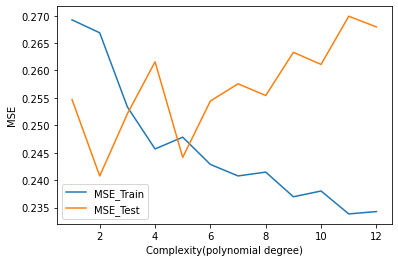

In [8]:

#maximum degree of polynomial
maxdegree = 12


#create arrays for results
polydegree = np.zeros(maxdegree)
MSE_OLS = np.zeros((maxdegree,2))



#cycle on polynomial degrees

for degree in range(maxdegree):
    
    X = create_X(x,y,degree+1)
        
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3)

    z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree+1
    
    z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test) 
    
    MSE_OLS[degree, 0] = mean_squared_error(z_train,z_train_tilde_ols)
    MSE_OLS[degree, 1] = mean_squared_error(z_test,z_test_tilde_ols)  
    

#plot the results
plt.plot(polydegree,MSE_OLS[:,0],label='MSE_Train')
plt.plot(polydegree,MSE_OLS[:,1],label='MSE_Test')
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.legend()
plt.show()

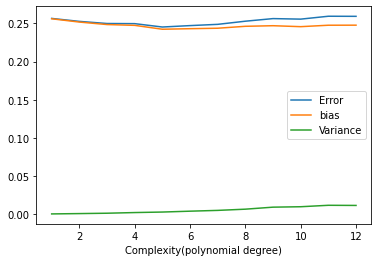

In [9]:
#maximum degree of polynomial
maxdegree = 12

#number of bootstrap resamplings
n_bs = 100


#create arrays for results
error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)
MSE_boot = np.zeros((maxdegree,2))



#cycle on polynomial degrees

for degree in range(maxdegree):
    
    X = create_X(x,y,degree + 1)
    
    #X = MatrixScaler(X)
    
    # Why needed random_state
    # The random_seed makes sure we take the same indices for spliting every time, and it is necessary to test the same test set
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=2)

    _, z_pred, mse = bootstrap_OLS(X_train, X_test, z_train, z_test, n_bs )
    z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree+1
    error[degree] = np.mean( np.mean((z_t - z_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (z_t - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(z_pred, axis=1, keepdims=True) )
    
    MSE_boot[degree, 0] = np.mean(mse[:,0]) 
    MSE_boot[degree, 1] = np.mean(mse[:,1])   
    

#plot the results
plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.xlabel('Complexity(polynomial degree)')

plt.legend()
plt.show()

## MSE Analysis

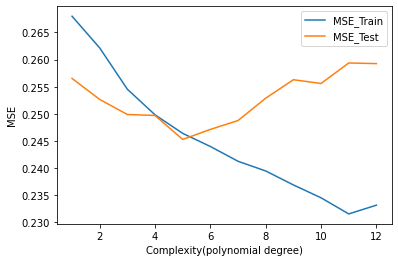

In [10]:
plt.figure()
plt.plot(polydegree,MSE_boot[:,0],label='MSE_Train')
plt.plot(polydegree,MSE_boot[:,1],label='MSE_Test')
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.legend()
plt.show()

## 3. Cross-Validation as resampling technique

- Main Question: Should we scale our data before the whole procedure, or during the procedure inbetween each split

_Note_: I have not scaled the data in the following sections


- Evaluate the MSE function from the test folds ( 5-10 folds)

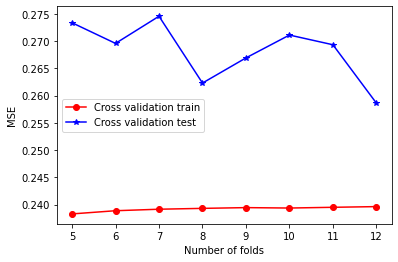

In [11]:
k_folds = range(5,13)
MSE_train_cross = np.zeros(len(k_folds))
MSE_test_cross = np.zeros(len(k_folds))

maxdegree = 12

X = create_X(x,y,maxdegree)

for i in range(len(k_folds)):
    MSE_train_cross[i], MSE_test_cross[i] =cross_validation_OLS(k_folds[i],X,z)

plt.figure()
plt.plot(k_folds,MSE_train_cross,"o-",c="r",label="Cross validation train")
plt.plot(k_folds,MSE_test_cross,"*-",c="b",label="Cross validation test")
plt.xlabel('Number of folds')
plt.ylabel('MSE')
plt.legend()
plt.show()


### Comparison Cross-validation and Bootstrap

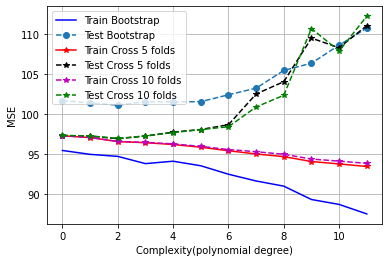

In [16]:


maxdegree = 12

MSE_train_boot = np.zeros(maxdegree)
MSE_test_boot = np.zeros(maxdegree)

k_folds = [5,10]

MSE_train_cross = np.zeros((maxdegree,2))
MSE_test_cross = np.zeros((maxdegree,2))

for degree in range(maxdegree):
    
    X = create_X(x,y,degree)
    #X = MatrixScaler(X)
    
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test)
    
    _, z_pred, mse = bootstrap_OLS(X_train, X_test, z_train, z_test, n_bs )
    z_t = z_test.reshape(len(z_test),1)
    MSE_train_boot[degree] = np.mean(mse[:,0])
    MSE_test_boot[degree] = np.mean(mse[:,1])
    for i  in range(len(k_folds)):
        k = k_folds[i]
        MSE_train_cross[degree,i],MSE_test_cross[degree,i] = cross_validation_OLS(k,X,z)

plt.figure()
plt.plot(range(maxdegree),MSE_train_boot,"b-",label = 'Train Bootstrap')
plt.plot(range(maxdegree),MSE_test_boot,"o--",label = 'Test Bootstrap')
plt.plot(range(maxdegree),MSE_train_cross[:,0],"r*-", label ='Train Cross 5 folds' )
plt.plot(range(maxdegree),MSE_test_cross[:,0],"k*--", label = 'Test Cross 5 folds' )
plt.plot(range(maxdegree),MSE_train_cross[:,1],"m*--", label ='Train Cross 10 folds' )
plt.plot(range(maxdegree),MSE_test_cross[:,1],"g*--", label = 'Test Cross 10 folds' )
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.show()

Comment results of this figure: 

- We see that the training MSE for all types of resampling follow a decreasing tendency with complexity, while the test MSE decrease until a certain complexity threshold. This common trends imply that we have found the optimal complexity of our system, around 5.

_The thing that is bothering me is the MSE values of around 100..._

## 4. Ridge Regression on Franke Function

- Linear regression

- Bootstrap analysis like in section b) (for same polynomials)

- Cross-validation part like c) , but with different lambdas

- Compare all results , and the dependence on lambda

- Bias Variance trade off as a function of lambda (using bootstrap resampling method)



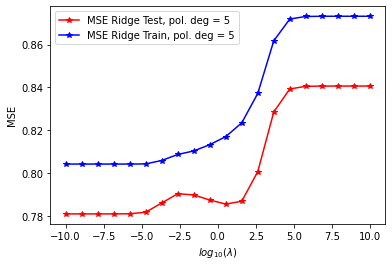

lambda to obtain miminum MSE: 1e-10
0.7808971316291692
0.7808971782499096
0.7808977045049104
0.7809036430036373
0.7809704108810256
0.7816854920381772
0.7859890697444253
0.7903169536568845
0.7897759765154063
0.7873962016539814
0.7854849674979201
0.7868064412118224
0.8006622308407519
0.82851552972193
0.8392516761070768
0.8404774459676106
0.8405887771103736
0.8405986616183436
0.8405995374274989
0.8405996150138846


In [33]:

#degree of the polynomial
maxdegree = 5

#setup design matrix with polynomial model
X = create_X(x,y,maxdegree)



#X = MatrixScaler(X)

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3,random_state=2)


#define interval of lambdas
nlambdas = 20
lambd = np.logspace(-10, 10, nlambdas)

MSE_train_Ridge = np.zeros(len(lambd))
MSE_test_Ridge = np.zeros(len(lambd))

#
for i in range(len(lambd)):
    
    z_tilde_train, z_tilde_test = Ridge(X_train,X_test,z_train,z_test,lambd[i])
    
    
    MSE_train_Ridge[i] = mean_squared_error(z_train, z_tilde_train)
    MSE_test_Ridge[i] = mean_squared_error(z_test, z_tilde_test)


plt.figure()
plt.plot(np.log10(lambd), MSE_test_Ridge, 'r*-', label = 'MSE Ridge Test, pol. deg = {}'.format(maxdegree))
plt.plot(np.log10(lambd), MSE_train_Ridge, 'b*-', label = 'MSE Ridge Train, pol. deg = {}'.format(maxdegree))

plt.xlabel('$log_{10}(\lambda)$')
plt.ylabel('MSE')
plt.legend()
plt.show()
print('lambda to obtain miminum MSE:', lambd[np.argmin(MSE_test_Ridge)])
for i in range(len(lambd)):
    print(MSE_test_Ridge[i])

### Ridge Bootstrap

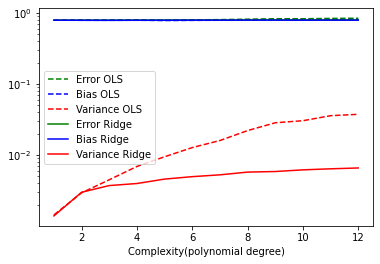

In [35]:


#select value of lambda
lambd = 10**-1


maxdegree = 12

n_bootstrap = 100

#prepare arrays for output

error_ols = np.zeros(maxdegree)
bias_ols = np.zeros(maxdegree)
variance_ols = np.zeros(maxdegree)

error_ridge = np.zeros(maxdegree)
bias_ridge = np.zeros(maxdegree)
variance_ridge = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

MSE_boot_ridge = np.zeros((maxdegree,2))
MSE_boot_ols = np.zeros((maxdegree,2))


#cycle on degrees of polynomial
for degree in range(maxdegree):
    
    #create design matrix (starting from degree 1)
    X = create_X(x,y,degree+1)
    #rescale design matrix
    #X = MatrixScaler(X)
    
    #train-test split
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
 
    #
    z_train_ols, z_pred_ols, mse_ols = bootstrap_OLS(X_train, X_test,z_train, z_test, n_bootstrap)
    z_train_ridge, z_pred_ridge, mse_ridge = bootstrap_Ridge(X_train, X_test, z_train, z_test, n_bootstrap, lambd)
    
    #reshape test values
    z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree + 1
    
    #calculate error, bias, variance for Ridge regression
    error_ridge[degree] = np.mean( np.mean((z_t - z_pred_ridge)**2, axis=1, keepdims=True) )
    bias_ridge[degree] = np.mean( (z_t - np.mean(z_pred_ridge, axis=1, keepdims=True))**2 )
    variance_ridge[degree] = np.mean( np.var(z_pred_ridge, axis=1, keepdims=True) )
    
    #calculate error, bias, variance for OLS regression
    error_ols[degree] = np.mean( np.mean((z_t - z_pred_ols)**2, axis=1, keepdims=True) )
    bias_ols[degree] = np.mean( (z_t - np.mean(z_pred_ols, axis=1, keepdims=True))**2 )
    variance_ols[degree] = np.mean( np.var(z_pred_ols, axis=1, keepdims=True) )

    MSE_boot_ols[degree, 0] = np.mean(mse_ols[:,0]) 
    MSE_boot_ols[degree, 1] = np.mean(mse_ols[:,1]) 
    
    MSE_boot_ridge[degree, 0] = np.mean(mse_ridge[:,0]) 
    MSE_boot_ridge[degree, 1] = np.mean(mse_ridge[:,1])  
 
    
plt.plot(polydegree, error_ols, "--g" , label='Error OLS')
plt.plot(polydegree, bias_ols,"--b", label='Bias OLS')
plt.plot(polydegree, variance_ols, "--r", label='Variance OLS')

plt.plot(polydegree, error_ridge, "g", label='Error Ridge')
plt.plot(polydegree, bias_ridge, "b", label='Bias Ridge')
plt.plot(polydegree, variance_ridge, "r", label='Variance Ridge')

plt.xlabel('Complexity(polynomial degree)')

plt.yscale("log")

plt.legend()
plt.show()

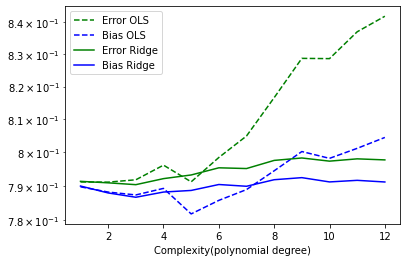

In [36]:
plt.plot(polydegree, error_ols, "--g" , label='Error OLS')
plt.plot(polydegree, bias_ols,"--b", label='Bias OLS')
#plt.plot(polydegree, variance_ols, "--r", label='Variance OLS')

plt.plot(polydegree, error_ridge, "g", label='Error Ridge')
plt.plot(polydegree, bias_ridge, "b", label='Bias Ridge')
#plt.plot(polydegree, variance_ridge, "r", label='Variance Ridge')

plt.xlabel('Complexity(polynomial degree)')

plt.yscale("log")

plt.legend()
plt.show()

### MSE Analysis

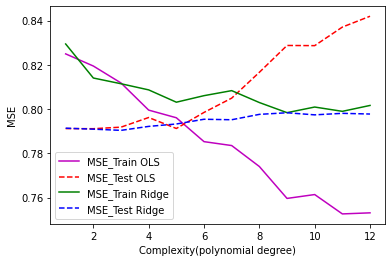

In [38]:
plt.figure()
plt.plot(polydegree,MSE_boot_ols[:,0],"m-",label='MSE_Train OLS')
plt.plot(polydegree,MSE_boot_ols[:,1],"r--",label='MSE_Test OLS')
plt.plot(polydegree,MSE_boot_ridge[:,0],"g-",label='MSE_Train Ridge')
plt.plot(polydegree,MSE_boot_ridge[:,1],"b--",label='MSE_Test Ridge')
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Ridge Cross Validation

In [ ]:
nlambdas = 20
lambd = np.logspace(-4, 4, nlambdas)
max_degree = np.arange(1,10,1)
datapoints = 100
MSE_test_BRidge = np.zeros((len(lambd), len(max_degree)))
for degree in range(len(max_degree)):
    X = create_X(x,y,max_degree[degree])
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    for i in range(len(lambd)):
        _,_,MSE_BRidge = bootstrap_Ridge(X_train, X_test,z_train, z_test, datapoints, lambd[i])
        MSE_test_BRidge[i,degree] = np.mean(MSE_BRidge[:,1]) # for test data set only

In [13]:
# It could be interesting to see how the noise affects the MSE of the 
# train and test data

amp = np.array([0.0 , 0.01, 0.1 , 10 ])
for i in range(len(amp)):
    noise = amp[i]*np.random.randn(X.shape[0])
    z = FrankeFunction(X[:,1],X[:,2]) + noise
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3)


    beta_ols = np.linalg.pinv(X_train.T@X_train)@(X_train.T)@z_train

    z_train_tilde_ols = X_train@beta_ols
    z_test_tilde_ols = X_test@beta_ols

    mse_train = mean_squared_error(z_train,z_train_tilde_ols)
    mse_test = mean_squared_error(z_test,z_test_tilde_ols)

    r2_train = r2_score(z_train,z_train_tilde_ols)
    r2_test = r2_score(z_test,z_test_tilde_ols)
    print('MSE Train for {}'.format(amp[i]))
    print(mse_train)
    print('MSE Test')
    print(mse_test)
    print('')
    

MSE Train for 0.0
7.534030180580748e-05
MSE Test
6.40728861834428e-05

MSE Train for 0.01
0.00016865776809174698
MSE Test
0.0002044701027208151

MSE Train for 0.1
0.00967535654220954
MSE Test
0.010432196051135968

MSE Train for 10.0
90.4544650029623
MSE Test
106.80348550580193



In [14]:
# We havent computed the variances for the parameters...
Varz = Variance(z)
VarPar = Varz*np.diagonal(np.linalg.inv(X.T.dot(X)))
np.sqrt(VarPar)

NameError: name 'Variance' is not defined

In [ ]:
beta_ols

In [ ]:
#1.  We have also done no scaling of the data
#2. We have not calculated the confidence intervals for the parameters

In [ ]:
# For finding for example the 95% there may be multiple ways of doing it
# One is repeating the fit 100 times, see where 95 percent of values
# fall and plot this on an histogram

# The only problem is we have 21 parameters, so no way we can compare all
'''
For high degrees of freedom the t distribution resembles a gaussian
SO the variance gives 1sigma, 68% of CI, 2sigma 95% ... 
Should we check this numerically? for at least 1 parameter?
'''

In [ ]:
# Now I want to find the MSE as a function of the model complexity
max_deg = 15 

degree = np.arange(1,max_deg +1,1)
MSETrain = np.zeros(max_deg)
MSETest = np.zeros(max_deg)
for i in range(max_deg):
    dof = degree[i]
    X = create_X(x,y,dof)
    z = FrankeFunction(X[:,1],X[:,2])
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3)
    beta_ols = np.linalg.pinv(X_train.T@X_train)@(X_train.T)@z_train

    z_train_tilde_ols = X_train@beta_ols
    z_test_tilde_ols = X_test@beta_ols

    MSETrain[i] = mean_squared_error(z_train,z_train_tilde_ols)
    MSETest[i] = mean_squared_error(z_test,z_test_tilde_ols)

In [ ]:
plt.figure()

plt.plot(degree,MSETrain,label='MSE_Train')
plt.plot(degree,MSETest,label='MSE_Test')
plt.xlabel('Complexity(degrees of freedom)')
plt.ylabel('MSE')
plt.legend()
plt.show()